**ResNext Model: Unimodal**

Submitted by: Akriti Gupta, Bhumika Singhal and Namita Shukla 


In this notebook, we are testing our dataset on a unimodal in which pre-processed images from which text is removed is sent. The main aim of the notebook is to study the number of signals received by using only images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the required modules

In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [8]:
import pandas as pd
train = pd.read_json('/content/drive/MyDrive/522-project/train.jsonl',lines=True)
val = pd.read_json('/content/drive/MyDrive/522-project/dev_unseen.jsonl',lines=True)

In [9]:
train_list = train['id'].tolist()

In [10]:
train_path = '/content/drive/MyDrive/522-project/img-new2/train'
validation_path = '/content/drive/MyDrive/522-project/img-new2/val'

### 2. Create PyTorch data generators

This section is used to load the data and splitting into validation and training set. Additionally, we also make use og transforms to check for invariance.

In [30]:
pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip


     \ 297 kB 1.7 MB/s
  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3838 sha256=9daee0e13061d9b6c0a4c55d6b91476224102ed3b46dd827315a620b6a610ade
  Stored in directory: /tmp/pip-ephem-wheel-cache-pxoe5yua/wheels/52/7b/7d/ce0e0ddbb7864877a0e31a96f883a928791ebfa6eaf7b52f87
Successfully built torchsampler


In [31]:
from torchsampler import ImbalancedDatasetSampler

In [34]:
from torchvision.transforms.transforms import RandomRotation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# transforms.Resize((224,224)),
# transforms.RandomRotation(45),
# transforms.ColorJitter(0.5,0.5,0.5),
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(train_path, data_transforms['train']),
    'validation': 
    datasets.ImageFolder(validation_path,data_transforms['validation'] )
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                sampler=ImbalancedDatasetSampler(image_datasets['train']),
                                batch_size=32,
                                #shuffle=True,
                                num_workers=0), 
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                sampler=ImbalancedDatasetSampler(image_datasets['validation']),
                                batch_size=32,
                                #shuffle=True,
                                num_workers=0) 
}

In [35]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0), 
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0) 
}

### 3. Create the network

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [37]:
model = models.resnext50_32x4d(pretrained=True)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [39]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [40]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix,roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve

### 4. Train the model

In [51]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
              print("in validation epoch")
              model.eval()

            running_loss = 0.0
            running_corrects = 0
            epoch_pred = []
            epoch_target = []
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                p = preds.cpu().numpy()
                t = labels.data.cpu().numpy()
                epoch_pred.extend(p)
                epoch_target.extend(t)
                
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            #print(epoch_pred)
            
            
            
            ##added for precision and all 
            precision, recall, f1, _ = precision_recall_fscore_support(epoch_target, epoch_pred, average='binary')
            acc = accuracy_score(epoch_target, epoch_pred)
            r= confusion_matrix(epoch_pred, epoch_target)
            fpr, tpr, _ = roc_curve(epoch_target, epoch_pred)
            roc_auc = roc_auc_score(epoch_pred, epoch_target)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            print('precision', precision)
            print('recall', recall)
            print('f1',f1)
            print('accuracy', acc)
            print("roc",roc_auc)
            #plt.figure(1)
            precision1, recall1, thresholds = precision_recall_curve(epoch_pred, epoch_target)

            #sns.heatmap(r,annot=True)
            plt.show()


            pyplot.plot(recall1, precision1, marker='.', label='ResNext')
            # axis labels
            print("Precison Vs Recall")
            pyplot.xlabel('Recall')
            pyplot.ylabel('Precision')
            pyplot.legend()
            pyplot.title('Precision Vs Recall', fontsize=20)
            # show the plot
            pyplot.show()

            print("ROC")

            # plt.plot([0, 1], [0, 1], 'k–')
            plt.plot(fpr, tpr, label='ResNext_ROC(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
            plt.show()

    return model

There is some error (even though the same version work on my own computer):

> RuntimeError: DataLoader worker (pid 56) is killed by signal: Bus error. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.
> RuntimeError: DataLoader worker (pid 59) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.
 
See [this issue](https://github.com/pytorch/pytorch/issues/5301) and [that thread](https://discuss.pytorch.org/t/dataloader-randomly-crashes-after-few-epochs/20433/2). Setting `num_workers=0` in `DataLoader` solved it.

Epoch 1/3
----------
train loss: 0.6121, acc: 0.6663
precision 0.5665680473372781
recall 0.1438227562898986
f1 0.22941000299490863
accuracy 0.6662775616083009
roc 0.6212140776919544
Precison Vs Recall


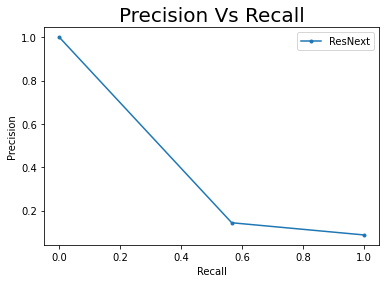

ROC


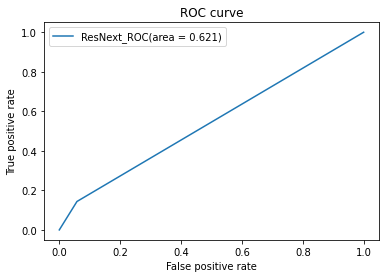

in validation epoch
validation loss: 0.6397, acc: 0.6461
precision 0.45454545454545453
recall 0.11677282377919321
f1 0.1858108108108108
accuracy 0.6461086637298091
roc 0.5596659585378361
Precison Vs Recall


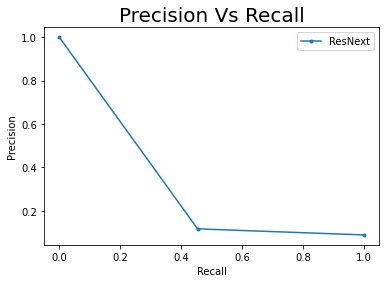

ROC


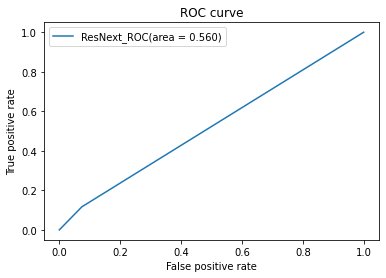

Epoch 2/3
----------
train loss: 0.6143, acc: 0.6638
precision 0.5602716468590832
recall 0.12392039053698836
f1 0.20295202952029523
accuracy 0.6638132295719844
roc 0.6163245609664044
Precison Vs Recall


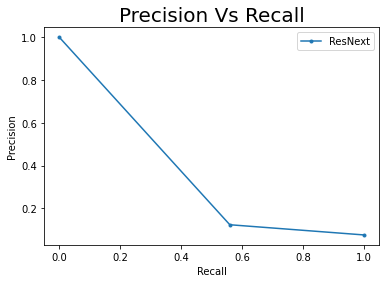

ROC


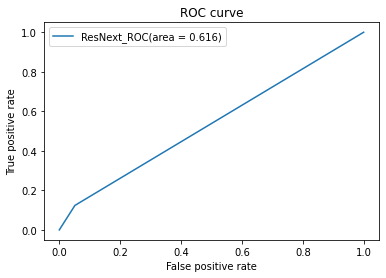

in validation epoch
validation loss: 0.6446, acc: 0.6439
precision 0.4551282051282051
recall 0.15074309978768577
f1 0.22647527910685805
accuracy 0.643906020558003
roc 0.5617266232937874
Precison Vs Recall


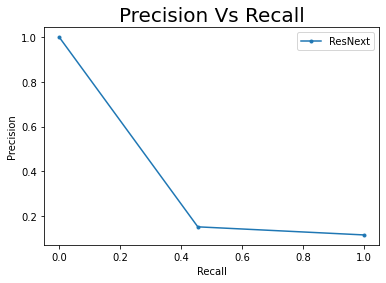

ROC


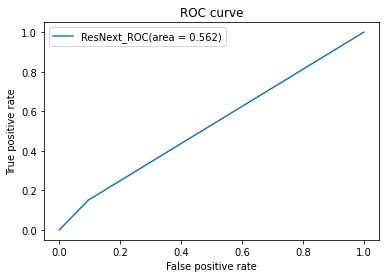

Epoch 3/3
----------
train loss: 0.6093, acc: 0.6684
precision 0.5732044198895028
recall 0.15583927900863687
f1 0.24505462060820782
accuracy 0.6683527885862516
roc 0.6257089949433199
Precison Vs Recall


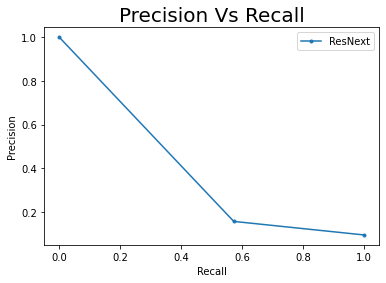

ROC


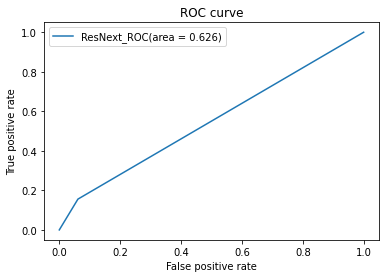

in validation epoch
validation loss: 0.6538, acc: 0.6079
precision 0.4065281899109792
recall 0.2908704883227176
f1 0.33910891089108913
accuracy 0.6079295154185022
roc 0.5403372656871969
Precison Vs Recall


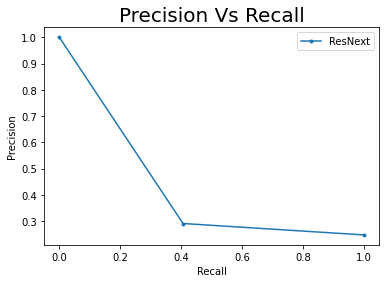

ROC


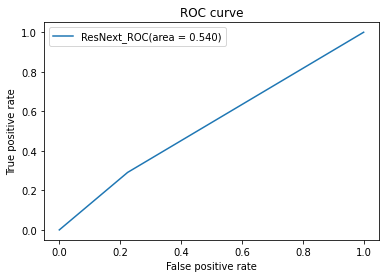

In [52]:
model_trained = train_model(model.to(device), criterion, optimizer, num_epochs=3)

### 5. Save and load the model

In [ ]:
!mkdir models
!mkdir models/pytorch

In [ ]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [ ]:
model = models.resnext50_32x4d(pretrained=True).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

### 6. Make predictions on sample test images

In [46]:
validation_img_paths = ["/1/98706.png",
                        "/0/14260.png",
                        "/0/30847.png",
                        "/1/58367.png",
                        "/1/93728.png",
                        "/1/31204.png"]
img_list = [Image.open('/content/drive/MyDrive/522-project/img-new2/val' + img_path) for img_path in validation_img_paths]

In [47]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [48]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 0.7151, -0.3479],
        [ 0.9790, -0.5064],
        [ 0.1756, -0.0328],
        [ 0.4101, -0.0102],
        [ 0.4765, -0.1975],
        [ 0.3556, -0.1155]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [49]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.7432686 , 0.25673145],
       [0.815378  , 0.184622  ],
       [0.55189854, 0.44810152],
       [0.60356194, 0.39643806],
       [0.662393  , 0.3376071 ],
       [0.6156632 , 0.38433686]], dtype=float32)

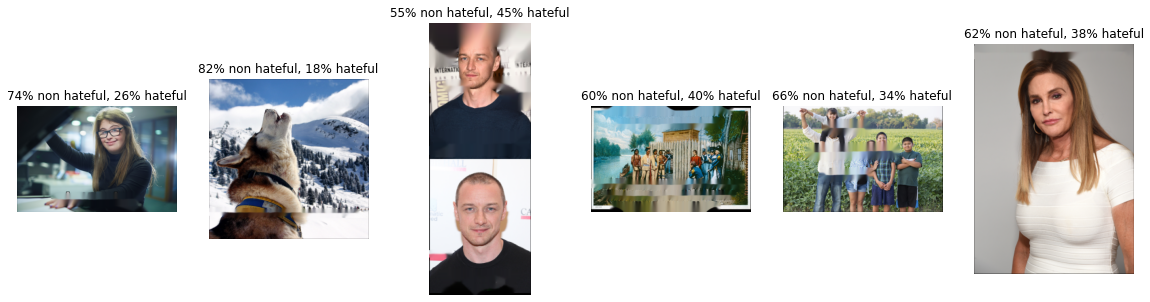

In [50]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% non hateful, {:.0f}% hateful".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)